# Exploring Backpropagation

These notes accompany the [Backpropagation and MLP lesson](https://course.fast.ai/Lessons/lesson13.html#lesson-resources) from Jeremy Howard.  The associated workbook can be found here: [https://github.com/fastai/course22p2/blob/master/nbs/03_backprop.ipynb](https://github.com/fastai/course22p2/blob/master/nbs/03_backprop.ipynb)

We start by loading MNIST.

In [41]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
import torch
from torch import tensor
from fastcore.test import test_close
from fastai.data.all import *
from fastai.vision.all import *
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

# path_data = Path('data')
# path_gz = path_data/'mnist.pkl.gz'
# with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
# x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/home/xstof/.fastai/data/mnist_png/training'),Path('/home/xstof/.fastai/data/mnist_png/testing')]

In [42]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 32

# Define the transformation to apply to the data
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),  # convert PIL image to PyTorch tensor
     transforms.Normalize((0.5,), (0.5,))])  # normalize the data to have a mean of 0.5 and std of 0.5

# Load the training dataset
trainset = torchvision.datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)

# Create a data loader for the training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

In [63]:
images.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

As we can see, every image is stored with one explicit channel.  Let's simplify this by removing this dimension. In addition we'll concatenate all pixels.

In [61]:
images = images.view(32,28*28)
images.shape

torch.Size([32, 784])

This means, we have a batch of 32 images, each with 784 pixels (28 * 28).  Visuially that looks like this:

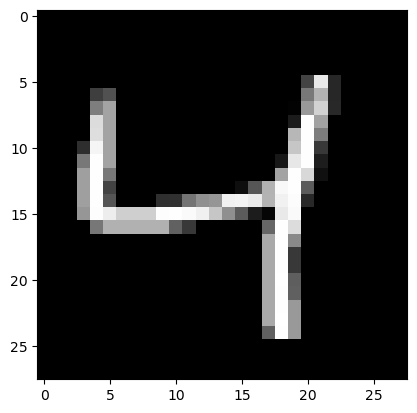

label for this image: 4


In [64]:
# Display the third image in the batch as an image
def show_image(img):
    plt.imshow(img.view(28,28), cmap='gray')
    plt.show()
show_image(images[2])
print(f"label for this image: {labels[2]}")